In [1]:
from gym.wrappers import FilterObservation, FlattenObservation, RecordVideo, RescaleAction, TimeLimit
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import unwrap_wrapper

from environment import ARESEA
from utils import FilterAction, RecordData

In [2]:
env = ARESEA()

check_env(env)

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
env = ARESEA()
env = FilterAction(env, [2,4], replace=0)

check_env(env)

In [2]:
env = ARESEA()
env = FlattenObservation(env)
env = RescaleAction(env, -1, 1)

check_env(env)

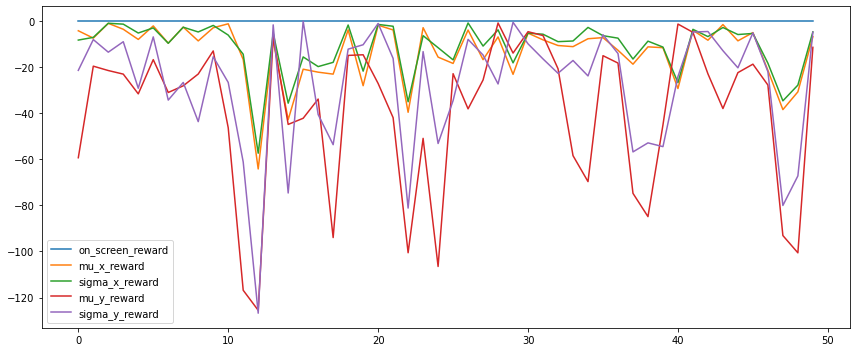

In [4]:
env = ARESEA()
# env = FilterAction(env, [2,4], replace=0)
env = TimeLimit(env, 50)
env = RecordData(env)
env = RescaleAction(env, -1, 1)

env.reset()
done = False
while not done:
    observation, reward, done, info = env.step(env.action_space.sample())

infos = unwrap_wrapper(env, RecordData).infos

# time_reward = [info["time_reward"] for info in infos]
on_screen_reward = [info["on_screen_reward"] for info in infos]
mu_x_reward = [info["mu_x_reward"] for info in infos]
sigma_x_reward = [info["sigma_x_reward"] for info in infos]
mu_y_reward = [info["mu_y_reward"] for info in infos]
sigma_y_reward = [info["sigma_y_reward"] for info in infos]

plt.figure(figsize=(12,5))
# plt.plot(time_reward, label="time_reward")
plt.plot(on_screen_reward, label="on_screen_reward")
plt.plot(mu_x_reward, label="mu_x_reward")
plt.plot(sigma_x_reward, label="sigma_x_reward")
plt.plot(mu_y_reward, label="mu_y_reward")
plt.plot(sigma_y_reward, label="sigma_y_reward")
plt.legend()
plt.tight_layout()
plt.show()

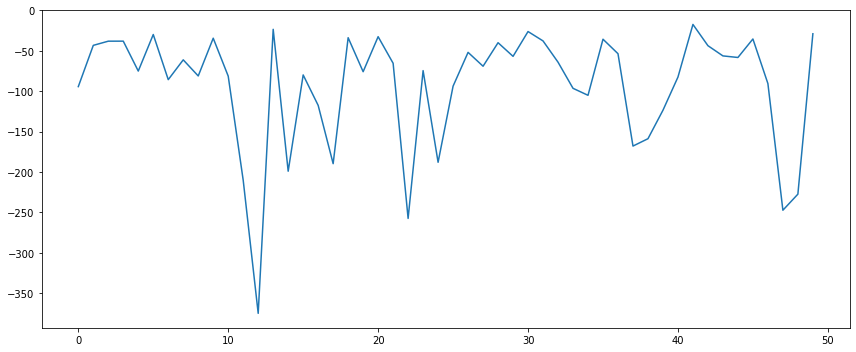

In [5]:
plt.figure(figsize=(12,5))
plt.plot(unwrap_wrapper(env, RecordData).rewards)
plt.tight_layout()
plt.show()

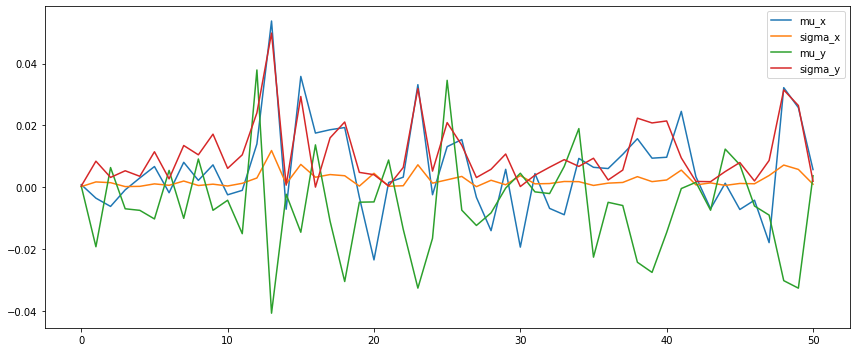

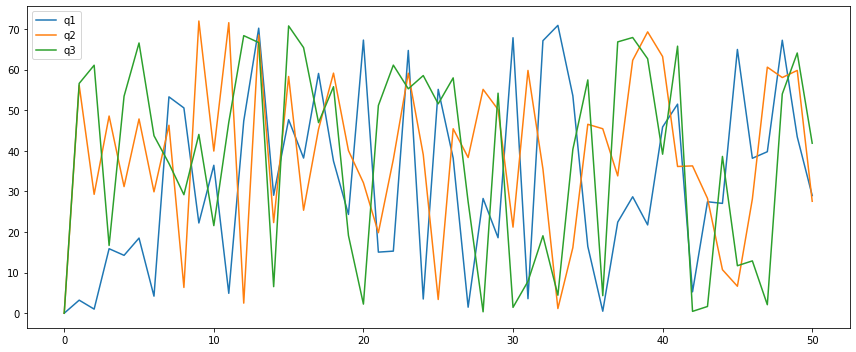

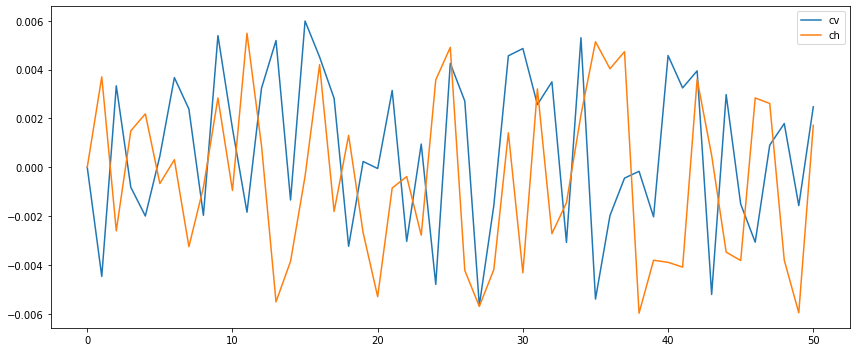

In [8]:
observations = unwrap_wrapper(env, RecordData).observations

mu_x = [observation["beam"][0] for observation in observations]
sigma_x = [observation["beam"][1] for observation in observations]
mu_y = [observation["beam"][2] for observation in observations]
sigma_y = [observation["beam"][3] for observation in observations]

q1 = [observation["magnets"][0] for observation in observations]
q2 = [observation["magnets"][1] for observation in observations]
cv = [observation["magnets"][2] for observation in observations]
q3 = [observation["magnets"][3] for observation in observations]
ch = [observation["magnets"][4] for observation in observations]

plt.figure(figsize=(12,5))
plt.plot(mu_x, label="mu_x")
plt.plot(sigma_x, label="sigma_x")
plt.plot(mu_y, label="mu_y")
plt.plot(sigma_y, label="sigma_y")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
plt.plot(q3, label="q3")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(cv, label="cv")
plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/ares-ea-rl/recordings_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


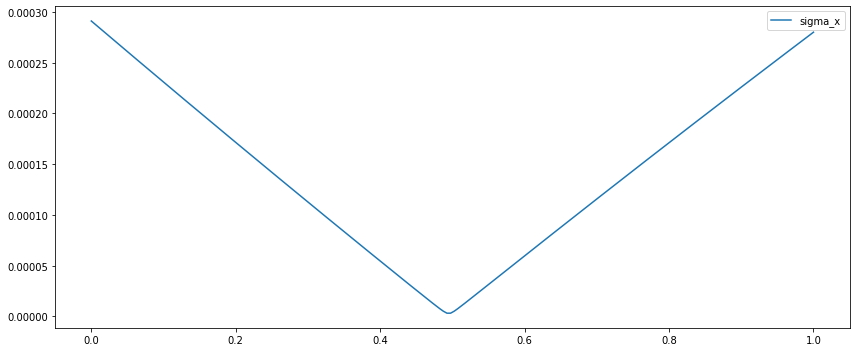

In [3]:
env = ARESEA()
env = FilterAction(env, [3], replace=0)
env = RecordVideo(env, video_folder="recordings_test")
env = RecordData(env)
env = RescaleAction(env, -3, 3)

k1s = np.linspace(0, 1, num=200)

observation = env.reset()
done = False
for k1 in k1s:
    observation, reward, done, info = env.step(k1)
env.close()

observations = unwrap_wrapper(env, RecordData).observations

sigma_x = [obs["beam"][1] for obs in observations]

plt.figure(figsize=(12,5))
plt.plot(k1s, sigma_x[1:], label="sigma_x")
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/ares-ea-rl/recordings_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


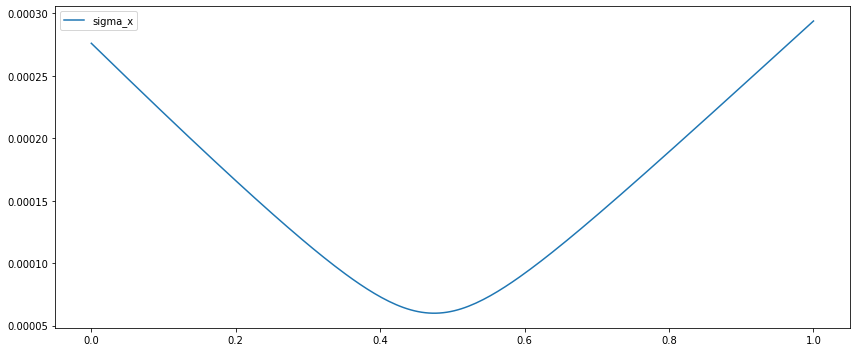

In [9]:
env = ARESEA()
env = FilterAction(env, [1], replace=0)
env = RecordVideo(env, video_folder="recordings_test")
env = RecordData(env)
env = RescaleAction(env, -5, 5)

k1s = np.linspace(0, 1, num=200)

observation = env.reset()
done = False
for k1 in k1s:
    observation, reward, done, info = env.step(k1)
env.close()

observations = unwrap_wrapper(env, RecordData).observations

sigma_x = [obs["beam"][1] for obs in observations]

plt.figure(figsize=(12,5))
plt.plot(k1s, sigma_x[1:], label="sigma_x")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
env = ARESEA()
env = FilterObservation(env, ["beam","magnets"])
env = FilterAction(env, [0,1,3], replace=0)
env = TimeLimit(env, max_episode_steps=50)
env = RecordData(env)
env = FlattenObservation(env)
env = RescaleAction(env, 0, 3)

check_env(env)

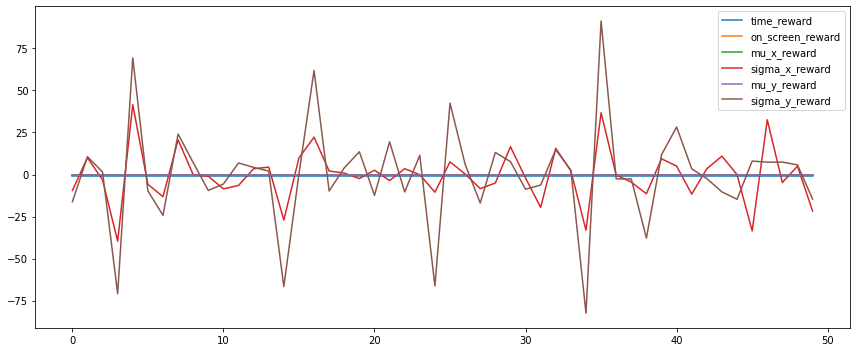

In [6]:
env.reset()
done = False
while not done:
    observation, reward, done, info = env.step(env.action_space.sample())

infos = unwrap_wrapper(env, RecordData).infos

time_reward = [info["time_reward"] for info in infos]
on_screen_reward = [info["on_screen_reward"] for info in infos]
mu_x_reward = [info["mu_x_reward"] for info in infos]
sigma_x_reward = [info["sigma_x_reward"] for info in infos]
mu_y_reward = [info["mu_y_reward"] for info in infos]
sigma_y_reward = [info["sigma_y_reward"] for info in infos]

plt.figure(figsize=(12,5))
plt.plot(time_reward, label="time_reward")
plt.plot(on_screen_reward, label="on_screen_reward")
plt.plot(mu_x_reward, label="mu_x_reward")
plt.plot(sigma_x_reward, label="sigma_x_reward")
plt.plot(mu_y_reward, label="mu_y_reward")
plt.plot(sigma_y_reward, label="sigma_y_reward")
plt.legend()
plt.tight_layout()
plt.show()

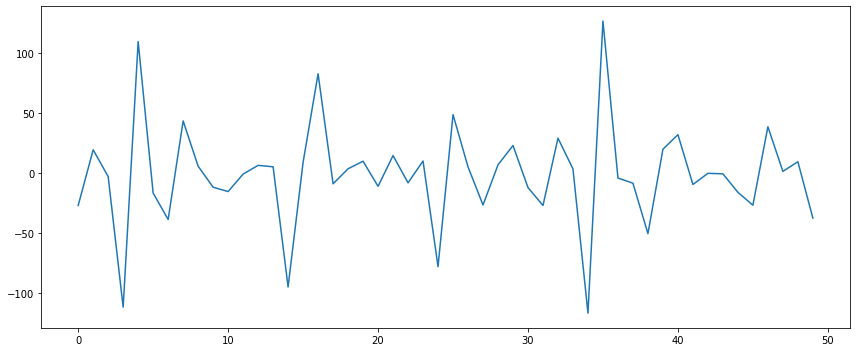

In [7]:
plt.figure(figsize=(12,5))
plt.plot(unwrap_wrapper(env, RecordData).rewards)
plt.tight_layout()
plt.show()

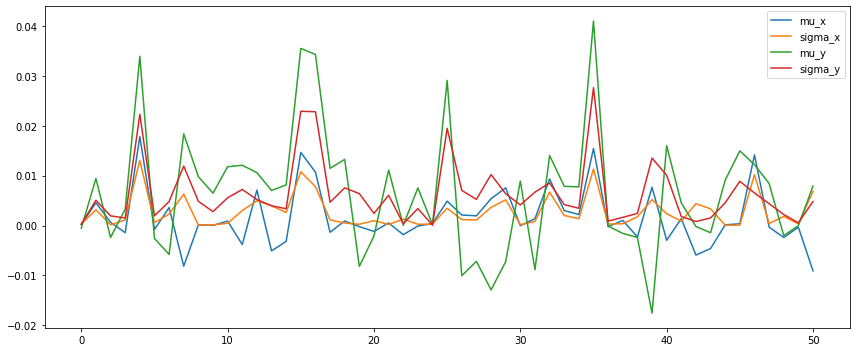

In [8]:
observations = unwrap_wrapper(env, RecordData).observations

mu_x = [observation["beam"][0] for observation in observations]
sigma_x = [observation["beam"][1] for observation in observations]
mu_y = [observation["beam"][2] for observation in observations]
sigma_y = [observation["beam"][3] for observation in observations]

plt.figure(figsize=(12,5))
plt.plot(mu_x, label="mu_x")
plt.plot(sigma_x, label="sigma_x")
plt.plot(mu_y, label="mu_y")
plt.plot(sigma_y, label="sigma_y")
plt.legend()
plt.tight_layout()
plt.show()

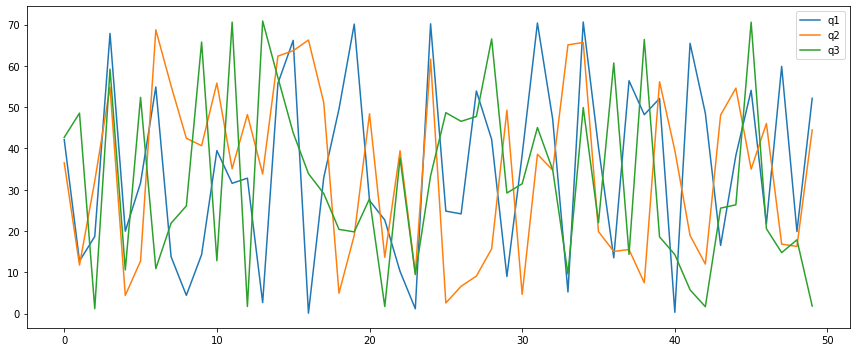

In [10]:
actions = unwrap_wrapper(env, RecordData).actions

q1 = [action[0] for action in actions]
q2 = [action[1] for action in actions]
q3 = [action[2] for action in actions]

plt.figure(figsize=(12,5))
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
plt.plot(q3, label="q3")
plt.legend()
plt.tight_layout()
plt.show()